<a href="https://colab.research.google.com/github/100abhishek/Resume_Ranker_AI/blob/main/Resume_Ranker_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**txt requirements**

*install required libraries*
1.   gradio
2.   pandas
3.   matplotlib
4.   scikit-learn
5.   sentence-transformers
6.   pdfplumber
7.   python-docx
8.   pandas


In [2]:
!pip install python-docx pdfplumber scikit-learn sentence-transformers pandas
!pip install gradio pandas matplotlib pdfplumber python-docx scikit-learn sentence-transformers
!python app.py

python3: can't open file '/content/app.py': [Errno 2] No such file or directory


In [3]:
# Imports
import os
import pdfplumber
import pandas as pd
from docx import Document
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from google.colab import files
import gradio as gr
import re  # required for JD keyword detection

model = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
# Upload resumes and job description
print("📤 Please upload multiple resumes and one job description file (PDF/DOCX).")
uploaded_files = files.upload()  # This creates the uploaded_files dictionary


📤 Please upload multiple resumes and one job description file (PDF/DOCX).


Saving Abhisheksingh_.pdf to Abhisheksingh_.pdf
Saving Aditya.pdf to Aditya.pdf
Saving Job Description.pdf to Job Description.pdf
Saving Linkedin resume.pdf to Linkedin resume.pdf
Saving Resume 1.pdf to Resume 1.pdf
Saving Resume 2.pdf to Resume 2.pdf
Saving Resume 3.pdf to Resume 3.pdf
Saving saurabhgupta.pdf to saurabhgupta.pdf
Saving vishal.pdf to vishal.pdf


In [ ]:
import os   # this function is used to delete files from the colab from the current version
import glob

# Delete all files with common resume extensions in the current directory
for file in glob.glob("*.pdf") + glob.glob("*.docx") + glob.glob("*.doc"):
    os.remove(file)

print("All uploaded resumes deleted.")

All uploaded resumes deleted.


In [5]:
# Function to extract text from PDF or DOCX
def extract_text(file_name):
    if file_name.lower().endswith('.pdf'):
        with pdfplumber.open(file_name) as pdf:
            return ' '.join(page.extract_text() or '' for page in pdf.pages)
    elif file_name.lower().endswith('.docx'):
        doc = Document(file_name)
        return ' '.join(para.text for para in doc.paragraphs)
    else:
        return ""


In [6]:
# Extract text from uploaded files
text_data = {}
for filename in uploaded_files:
    with open(filename, "wb") as f:
        f.write(uploaded_files[filename])  # it save file locally
    extracted = extract_text(filename)
    if extracted.strip():
        text_data[filename] = extracted

if not text_data:
    raise ValueError("❌ No valid files or empty content detected.")

print(f"✅ Loaded {len(text_data)} documents")


✅ Loaded 9 documents


In [7]:
# Define the function for classifying JD and Resume
def is_probable_jd(text, filename):
    jd_keywords = [
        "responsibilities", "requirements", "qualifications", "role", "job description",
        "skills", "preferred", "desired", "job summary", "position", "job title", "job overview"
    ]
    resume_keywords = [
        "education", "certifications", "projects", "declaration", "dob", "linkedin",
        "resume", "summary", "experience", "internship", "skills", "objective", "achievements"
    ]

    score = 0
    text_lower = text.lower()

    # JD keyword frequency
    jd_hits = sum(text_lower.count(word) for word in jd_keywords)
    score += jd_hits * 5

    # Resume keyword penalty
    resume_hits = sum(text_lower.count(word) for word in resume_keywords)
    score -= resume_hits * 4

    # Heuristic: Date pattern → likely resume
    date_pattern = r"(19|20)\d{2}"
    if len(re.findall(date_pattern, text)) >= 4:
        score -= 10

    # Heuristic: Filename suggests JD
    if "jd" in filename.lower() or "jobdesc" in filename.lower() or "description" in filename.lower():
        score += 20

    # Heuristic: Length - JD is usually shorter
    if 300 < len(text) < 2500:
        score += 10
    elif len(text) > 3000:
        score -= 10  # Resumes can be long

    return score

# Classify files into JD and Resume
jd_files = {}
resume_files = {}

for filename, text in text_data.items():
    jd_score = is_probable_jd(text, filename)
    if jd_score >= 0:
        jd_files[filename] = text
    else:
        resume_files[filename] = text

# Print classification summary
print("\nDocument Classification Summary:")
print(f"Job Descriptions Detected: {len(jd_files)}")
for f in jd_files:
    print(f"  - JD: {os.path.basename(f)}")

print(f"Resumes Detected: {len(resume_files)}")
for f in resume_files:
    print(f"  - Resume: {os.path.basename(f)}")



Document Classification Summary:
Job Descriptions Detected: 1
  - JD: Job Description.pdf
Resumes Detected: 8
  - Resume: Abhisheksingh_.pdf
  - Resume: Aditya.pdf
  - Resume: Linkedin resume.pdf
  - Resume: Resume 1.pdf
  - Resume: Resume 2.pdf
  - Resume: Resume 3.pdf
  - Resume: saurabhgupta.pdf
  - Resume: vishal.pdf


In [8]:
def get_top_overlap_keywords(text1, text2, top_n=5):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf = vectorizer.fit_transform([text1, text2])
    features = vectorizer.get_feature_names_out()
    vec1 = tfidf[0].toarray().flatten()
    vec2 = tfidf[1].toarray().flatten()

    # Multiply TF-IDF vectors to find overlapping terms
    overlap = vec1 * vec2
    top_indices = overlap.argsort()[::-1][:top_n]
    top_keywords = [features[i] for i in top_indices if overlap[i] > 0]

    return ', '.join(top_keywords)


In [9]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Initialize the model (Sentence-Transformer model)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the Job Descriptions
jd_embeddings = {}
for jd_filename, jd_text in jd_files.items():
    jd_embeddings[jd_filename] = model.encode([jd_text])  # Ensure it's a 2D array

# Score each resume against each job description
results = []

# Iterate over each resume
for resume_filename, resume_text in resume_files.items():
    resume_embedding = model.encode([resume_text])  # Ensure it's a 2D array

    # Iterate over each Job Description (jd_embedding)
    for jd_filename, jd_embedding in jd_embeddings.items():
        # Ensure both embeddings are 2D arrays
        score = cosine_similarity(resume_embedding, jd_embedding)[0][0]  # Compute similarity between 2D arrays
        top_keywords = get_top_overlap_keywords(resume_text, jd_text)
        results.append((resume_filename, jd_filename, round(score * 100, 2), top_keywords))

# 📈 Display Results in a DataFrame
results_df = pd.DataFrame(results, columns=["Resume", "Job Description", "Match %", "Top Keywords"])
results_df = results_df.sort_values(by="Match %", ascending=False).reset_index(drop=True)

# Display results
print("\n🎯 Resume Match Results:\n")
pd.set_option('display.float_format', '{:.2f}'.format)
print(results_df)



🎯 Resume Match Results:

                Resume      Job Description  Match %  \
0           vishal.pdf  Job Description.pdf    45.01   
1         Resume 1.pdf  Job Description.pdf    34.39   
2   Abhisheksingh_.pdf  Job Description.pdf    32.03   
3         Resume 2.pdf  Job Description.pdf    28.85   
4           Aditya.pdf  Job Description.pdf    28.61   
5     saurabhgupta.pdf  Job Description.pdf    24.15   
6  Linkedin resume.pdf  Job Description.pdf    17.52   
7         Resume 3.pdf  Job Description.pdf    12.74   

                                Top Keywords  
0       data, analytics, team, work, product  
1                               work, skills  
2               data, sql, new, python, work  
3  data, product, skills, problem, technical  
4     data, new, member, problems, knowledge  
5          data, new, technical, learn, work  
6               data, new, team, key, intern  
7         new, intern, problem, skills, team  


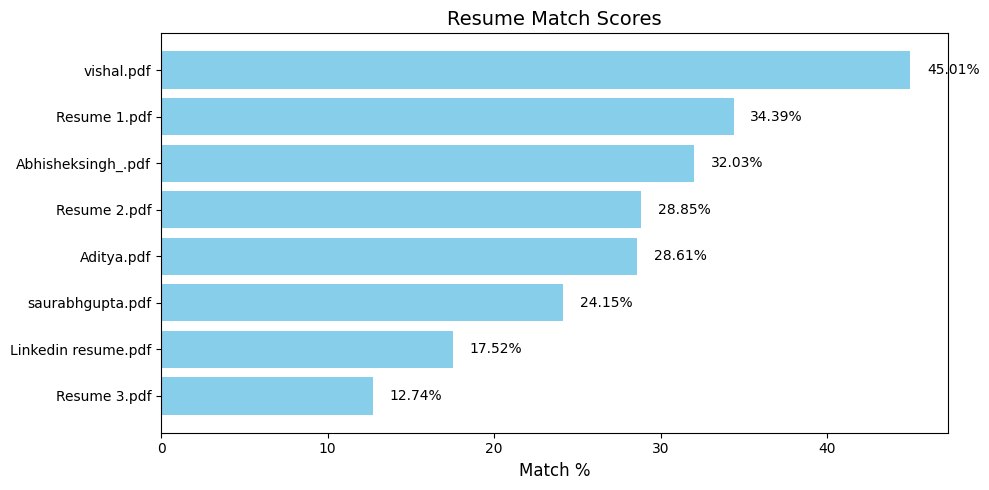

In [10]:
# 📊 Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
bars = plt.barh(results_df["Resume"], results_df["Match %"], color="skyblue")
plt.xlabel("Match %", fontsize=12)
plt.title("Resume Match Scores", fontsize=14)
plt.gca().invert_yaxis()  # Highest match on top

# Add labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', va='center')

plt.tight_layout()
plt.show()


In [11]:
!pip install gradio


In [12]:
import gradio as gr
import os
import tempfile
import re
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pdfplumber
from docx import Document
from sklearn.feature_extraction.text import TfidfVectorizer # import TfidfVectorizer

# Load the model once
model = SentenceTransformer("all-MiniLM-L6-v2")

# Extract text from PDF or DOCX
def extract_text(file_path, ext):
    try:
        if ext == 'pdf':
            with pdfplumber.open(file_path) as pdf:
                return ' '.join(page.extract_text() or '' for page in pdf.pages)
        elif ext == 'docx':
            return '\n'.join(p.text for p in Document(file_path).paragraphs)
    except Exception as e:
        return ''
    return ''

# Heuristic to identify JD vs Resume
def is_probable_jd(text, filename):
    jd_keywords = [
        "responsibilities", "requirements", "qualifications", "job description", "skills",
        "preferred", "desired", "job summary", "position", "job title"
    ]
    resume_keywords = [
        "education", "projects", "certifications", "linkedin", "experience", "internship", "objective"
    ]
    text_lower = text.lower()
    jd_score = sum(text_lower.count(k) for k in jd_keywords)
    resume_score = sum(text_lower.count(k) for k in resume_keywords)
    filename_hint = "jd" in filename.lower() or "description" in filename.lower()
    return jd_score + (20 if filename_hint else 0) > resume_score


def extract_top_keywords(text1, text2, top_n=5): # define extract_top_keywords outside of other function
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf = vectorizer.fit_transform([text1, text2])
    feature_names = vectorizer.get_feature_names_out()
    diff = tfidf[0] - tfidf[1]
    abs_diff = abs(diff.toarray()[0])
    top_indices = abs_diff.argsort()[-top_n:][::-1]
    return [feature_names[i] for i in top_indices]

# Main scoring function
def score_resumes(files):
    try:
        if not files or len(files) < 2:
            raise gr.Error("Please upload at least 1 JD and 1 resume.")

        text_data = {}
        jd_files = {}
        resume_files = {}

        for file in files:
            ext = file.name.split('.')[-1].lower()
            text = extract_text(file.name, ext)
            text_data[file.name] = text

        # Classify each file
        for filename, text in text_data.items():
            if is_probable_jd(text, filename):
                jd_files[filename] = text
            else:
                resume_files[filename] = text

        if not jd_files:
            raise gr.Error("No Job Description detected.")
        if not resume_files:
            raise gr.Error("No resumes detected.")

        results = []
        for resume_name, resume_text in resume_files.items():
            resume_embedding = model.encode([resume_text])
            for jd_name, jd_text in jd_files.items():
                jd_embedding = model.encode([jd_text])
                sim = cosine_similarity(resume_embedding, jd_embedding)[0][0]
                top_keywords = extract_top_keywords(jd_text, resume_text) # call extract_top_keywords
                results.append((
                    os.path.basename(resume_name),
                    os.path.basename(jd_name),
                    round(sim * 100, 2),
                    ', '.join(top_keywords)
                 ))

        results_df = pd.DataFrame(results, columns=["Resume", "Job Description", "Match %", "Top Keywords"])
        results_df = results_df.sort_values(by="Match %", ascending=False).reset_index(drop=True)

        # Save results to CSV
        csv_path = os.path.join(tempfile.gettempdir(), "candidate_match_results.csv")
        results_df.to_csv(csv_path, index=False)

        # Plot
        plt.figure(figsize=(10, 4))
        bars = plt.barh(results_df["Resume"], results_df["Match %"], color="skyblue")
        plt.xlabel("Match %")
        plt.title("Resume Match Score")
        plt.gca().invert_yaxis()
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', va='center')
        plot_path = os.path.join(tempfile.gettempdir(), "match_plot.png")
        plt.tight_layout()
        plt.savefig(plot_path)
        plt.close()

        return results_df, plot_path, csv_path


    except Exception as e:
        import traceback
        print(traceback.format_exc())
        raise gr.Error(f"⚠️ Something went wrong:\n\n{e}")

In [13]:
interface = gr.Interface(
    fn=score_resumes,
    inputs=gr.File(file_types=[".pdf", ".docx"], file_count="multiple", label="Upload Resumes and JDs"),
    outputs=[
        gr.Dataframe(headers=["Resume", "Job Description", "Match %", "Top Keywords"], label="Resume Match Scores"),
        gr.Image(type="filepath", label="Match Score Chart"),
        gr.File(label="Download CSV")
    ],
    title="Resume Ranker AI",
    description="Upload resumes and job descriptions (.pdf or .docx). The app will automatically detect and score matches."
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://660f00ae459e76f93d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
!jupyter nbconvert --to script Resume_Ranker_AI.ipynb

[NbConvertApp] Converting notebook Resume_Ranker_AI.ipynb to script
[NbConvertApp] Writing 11444 bytes to Resume_Ranker_AI.txt


In [2]:
!ls Resume_Ranker_AI.py


Resume_Ranker_AI.py


In [16]:
from google.colab import files
files.download('Resume_Ranker_AI.py')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>